In [1]:
# Project: Mineração dos microdados do ENEM 2019
# Description: Ainda em desenvolvimento.
# Author: Danilo (@ryganon).

# Observação: este ainda é um estudo em desenvolvimento. As estatísticas geradas e exibidas
# são apenas para estudo e análise prévia da base de dados.

## Configuração

In [1]:
import graphviz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
import missingno as msno

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

In [2]:
path_microdados = "dados_enem_2019_filtrado_pb.csv"
sns.set(color_codes=True)

## Documentação

* https://towardsdatascience.com/3-python-visualization-libraries-you-must-know-as-a-data-scientist-8d0cd25e1c73
* https://seaborn.pydata.org/tutorial/relational.html
* https://seaborn.pydata.org/tutorial/axis_grids.html
* https://seaborn.pydata.org/examples/many_pairwise_correlations.html


## Pré-processamento do CSV

* Colunas para filtro:  
```python
['IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO'] == 1
```

```python
['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'] == 1
```

In [ ]:
def converter_dados_categoricos(dados):
    filtro = ['Q001','Q002','Q003','Q004','Q005','Q006',
              'Q010','Q011','Q022','Q024','Q025'] 
    
    for col in filtro:
        dados[col] = dados[col].astype('category').cat.codes
    return dados

def dados_localizacao(dados):
    # 1 digito = regiao
    # 1,2 digitos = UF
    # 3,4,5,6 digitos = cod. municipio
    return (dados[0:1], dados[0:2], dados[2:6])

def filtro_dados(path):
    df_result = pd.DataFrame()
    data_iter = pd.read_csv(path, iterator=True, chunksize=100000)
    
    # filtrando os dados seguindo as regras
    for chunk in data_iter:    
        # filtro: caso o candidato declare necessidade de atendimento especializado
        chunk_filter = chunk.loc[(chunk['IN_CEGUEIRA'] == 1) | 
                           (chunk['IN_SURDEZ'] == 1) |
                           (chunk['IN_DEFICIENCIA_AUDITIVA'] == 1) |
                           (chunk['IN_SURDO_CEGUEIRA'] == 1) |
                           (chunk['IN_DEFICIENCIA_FISICA'] == 1) |
                           (chunk['IN_DEFICIENCIA_MENTAL'] == 1) |
                           (chunk['IN_DEFICIT_ATENCAO'] == 1) |
                           (chunk['IN_DISLEXIA'] == 1) |
                           (chunk['IN_DISCALCULIA'] == 1) |
                           (chunk['IN_AUTISMO'] == 1) |
                           (chunk['IN_VISAO_MONOCULAR'] == 1) |
                           (chunk['IN_OUTRA_DEF'] == 1) |
                           (chunk['IN_GESTANTE'] == 1) |
                           (chunk['IN_LACTANTE'] == 1) |
                           (chunk['IN_IDOSO'] == 1) |
                           (chunk['IN_ESTUDA_CLASSE_HOSPITALAR'] == 1) |
                           (chunk['IN_SEM_RECURSO'] == 1)]
        
        # filtro: criando coluna PRESENCA
        chunk_filter["PRESENCA"] = 1 # valor padrao
        # caso o candidato ausente em qualquer dia, PRESENCA = 0 
        chunk_filter.loc[(chunk['TP_PRESENCA_CN'] == 0) |
                  (chunk_filter['TP_PRESENCA_CH'] == 0) |
                  (chunk_filter['TP_PRESENCA_LC'] == 0) |
                  (chunk_filter['TP_PRESENCA_MT'] == 0), "PRESENCA"] = 0
        
         
        # filtro: sexo 
        chunk_filter.loc[(chunk['TP_SEXO'] == "M"), "TP_SEXO"] = 0
        chunk_filter.loc[(chunk['TP_SEXO'] == "F"), "TP_SEXO"] = 1
     
        # selecionando apenas os que não são treineiros
        chunk_filter = chunk_filter.loc[(chunk_filter['IN_TREINEIRO'] == 0)] 
        
        # finalizando loop
        df_result = df_result.append(chunk_filter)
        
    # convertendo colunas categóricas para inteiro
    df_result = converter_dados_categoricos(df_result) 
    
    # coletando dados de regiao, uf e municipio de residencia
    df_result["REGIAO_RESIDENCIA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_RESIDENCIA']))[0], axis=1)
    df_result["UF_RESIDENCIA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_RESIDENCIA']))[1], axis=1)
    df_result["MUNICIPIO_RESIDENCIA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_RESIDENCIA']))[2], axis=1)
    
    # coletando dados de regiao, uf e municipio da escola do candidato
    #df_result["REGIAO_ESCOLA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_ESC']))[0], axis=1)
    #df_result["UF_ESCOLA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_ESC']))[1], axis=1)
    #df_result["MUNICIPIO_ESCOLA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_ESC']))[2], axis=1)

    # coletando dados de regiao, uf e municipio do local de prova
    df_result["REGIAO_PROVA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_PROVA']))[0], axis=1)
    df_result["UF_PROVA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_PROVA']))[1], axis=1)
    df_result["MUNICIPIO_PROVA"] = df_result.apply(lambda row: dados_localizacao(str(row['CO_MUNICIPIO_PROVA']))[2], axis=1)
    
    return df_result

microdados = filtro_dados(path_microdados)

#Total geral dados: (32815, 51)

In [4]:
###################################
# Função para counterplot genérico
###################################
def eda_counterplot(dados, variavel, categorias, fig_size, order_bars = True, debug=False, exibe_cat=True, color_palette=None):
    
    # counter 
    counter = dados[variavel].value_counts()
    total = dados[variavel].count()
    if debug:
        print(counter)
        
    for index, value in counter.items():
        perc = (value * 100) / total
        print(categorias[index],":", value, '({:1.2f}%)'.format(perc))
        
    
    # reordenando categorias baseado na contagem
    categorias = [categorias[i] for i in list(counter.index)]
    f, ax = plt.subplots(figsize= fig_size)
    
    plot = sns.countplot(x = variavel, 
                         data = dados, 
                         hue = variavel, 
                         hue_order = list(counter.index), 
                         order = list(counter.index) if order_bars else None, 
                         dodge = False,
                         palette= color_palette)
                         

    # ajustando legendas
    if exibe_cat: 
        plot.legend(categorias)

###############################
# Função para plot categórico        
###############################
def eda_catplot(dados, col_alvo, col_comp, num_col=1, plot_height=4):
    
    # selecionando os candidatos que solicitaram atendimento
    dados_filtro = dados.loc[dados[col_comp] == 1]
    # selecionando as colunas de comparação
    dados_filtro = dados_filtro[[col_comp, col_alvo]]
    
    # counter 
    counter = dados_filtro[col_alvo].value_counts()
    total = dados_filtro[col_alvo].count()
    categorias = ["Ausente", "Presente"]    
    for index, value in counter.items():
        perc = (value * 100) / total
        print(categorias[index],":", value, '({:1.2f}%)'.format(perc))
    
    color_palette = sns.color_palette("GnBu_d", n_colors=2)
    sns.catplot(col_alvo, 
                col = col_comp, 
                col_wrap = num_col, 
                data = dados_filtro, 
                kind = "count", 
                height=plot_height, 
                palette=color_palette)
    
    
###############################
# Função para plot categórico        
###############################
def eda_catplot_geral(dados, col_alvo, col_comp, num_col=1, plot_height=4):
    
    # selecionando as colunas de comparação
    dados_filtro = dados[[col_comp, col_alvo]]
    
    # counter 
    counter = dados_filtro[col_alvo].value_counts()
    total = dados_filtro[col_alvo].count()
    categorias = ["Ausente", "Presente"]    
    for index, value in counter.items():
        perc = (value * 100) / total
        print(categorias[index],":", value, '({:1.2f}%)'.format(perc))
    
    color_palette = sns.color_palette("GnBu_d", n_colors=2)
    sns.catplot(col_alvo, 
                col = col_comp, 
                col_wrap = num_col, 
                data = dados_filtro, 
                kind = "count", 
                height=plot_height, 
                palette=color_palette)

In [ ]:
'''
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1): 
    print("Dados:", microdados.shape)
    colunas = ["CO_MUNICIPIO_RESIDENCIA", "REGIAO_RESIDENCIA", "UF_RESIDENCIA", "MUNICIPIO_RESIDENCIA",
              "CO_MUNICIPIO_ESC", "REGIAO_ESCOLA", "UF_ESCOLA", "MUNICIPIO_ESCOLA",
              "CO_MUNICIPIO_PROVA", "REGIAO_PROVA", "UF_PROVA", "MUNICIPIO_PROVA"]
    #display(microdados[colunas].head(20))
    display(microdados.head(20))
'''

* Quantidade de candidatos treineiros (IN_TREINEIRO) : 
    * Não (0):    30233
    * Sim (1):     2582
* Total filtrado de dados: (30233, 51)

### Análise de dados com valores NA

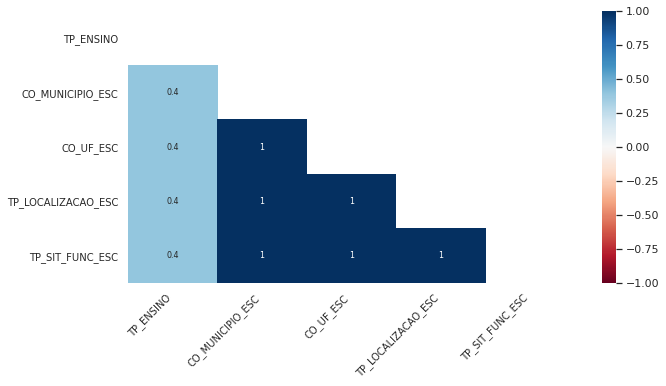

In [5]:
msno.heatmap(microdados, figsize=(10, 5),fontsize=10)

# plt.savefig('heatmap.svg', bbox_inches = 'tight')

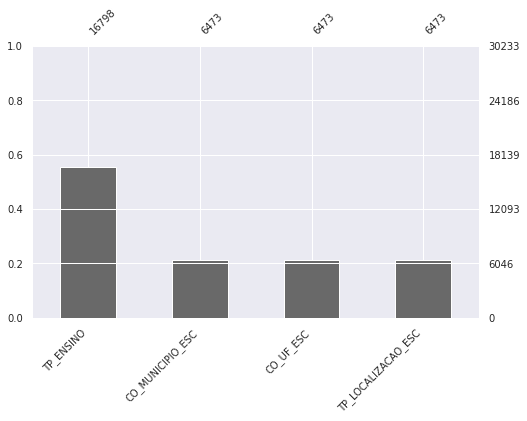

In [6]:
msno.bar(microdados[microdados.columns[microdados.columns.isin(['TP_ENSINO', 'CO_MUNICIPIO_ESC','CO_UF_ESC','TP_LOCALIZACAO_ESC','TP_SIT_FUN_ESC'])]],
        figsize=(8, 5),
        fontsize=10)
# plt.savefig('valores_nulos.svg', bbox_inches = 'tight')

# Análise Exploratória dos Dados




A seguir será apresentada uma análise univariada e multivariada dos dados. Para cada variável (feature/coluna do dataset) serão apresentados 



## Variável alvo

* Verificar a taxa de presença e ausência entre os candidatos.
* Observa-se uma quantidade significativa de ausências.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


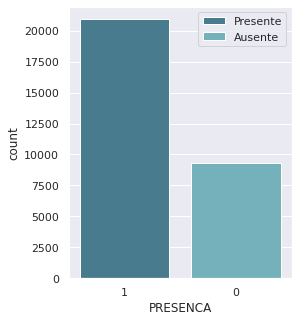

In [7]:
eda_counterplot(microdados, "PRESENCA", ["Ausente", "Presente"], (4,5), 
                color_palette=sns.color_palette("GnBu_d", n_colors=2))

# plt.savefig('var_presenca.svg', bbox_inches = 'tight')

## Faixa etária dos candidatos

* Entre os candidatos, a idade média gira em torno dos 24 anos.
* Idade mínima registrada de 12 anos e idade máxima de 91 anos.

min     12.000000
max     91.000000
mean    25.278735
Name: NU_IDADE, dtype: float64


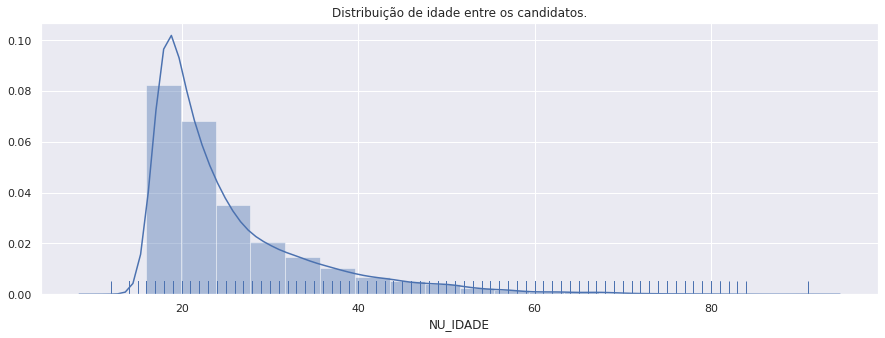

In [8]:
def eda_idade(dados):
    print(dados.NU_IDADE.describe()[["min", "max", "mean"]])
    
    f, ax = plt.subplots(figsize=(15, 5))
    ax.set_title('Distribuição de idade entre os candidatos.') 

    sns.distplot(microdados.NU_IDADE, bins=20, kde=True, rug=True)
        
eda_idade(microdados)

# plt.savefig('var_idade.svg', bbox_inches = 'tight')

## Distribuição entre sexos

* A proporção de candidatos do sexo feminino é maior que do sexo masculino.

Feminino : 17603 (58.22%)
Masculino : 12630 (41.78%)


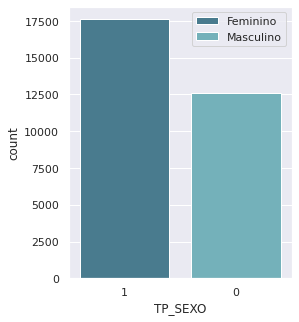

In [9]:
eda_counterplot(microdados, "TP_SEXO", ["Masculino", "Feminino"], (4,5), 
                color_palette=sns.color_palette("GnBu_d", n_colors=2))

# plt.savefig('var_presenca.svg', bbox_inches = 'tight')

## Estado civil

* O estado civil dos candidatos, em sua grande maioria, é de solteiros.

Solteiro(a) : 24115 (79.76%)
Casado(a)/Mora com companheiro(a) : 3426 (11.33%)
Não informado : 1772 (5.86%)
Divorciado(a)/Desquitado(a)/Separado(a) : 825 (2.73%)
Viúvo(a) : 95 (0.31%)


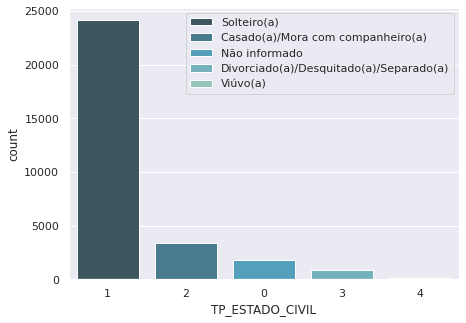

In [10]:
# Estado civil
categorias = {0: "Não informado", 
              1: "Solteiro(a)", 
              2: "Casado(a)/Mora com companheiro(a)", 
              3: "Divorciado(a)/Desquitado(a)/Separado(a)", 
              4: "Viúvo(a)"}

eda_counterplot(microdados, "TP_ESTADO_CIVIL", categorias, (7,5),
               color_palette=sns.color_palette("GnBu_d", n_colors=5))

# plt.savefig('var_estado_civil.svg', bbox_inches = 'tight')

## Sobre cor e raça

* Existe uma proporção similar entre candidatos pardos e brancos.
 * Faremos a união das duas categorias.

Parda : 13090 (43.30%)
Branca : 12442 (41.15%)
Preta : 3188 (10.54%)
Não declarado : 754 (2.49%)
Amarela : 583 (1.93%)
Indígena : 176 (0.58%)


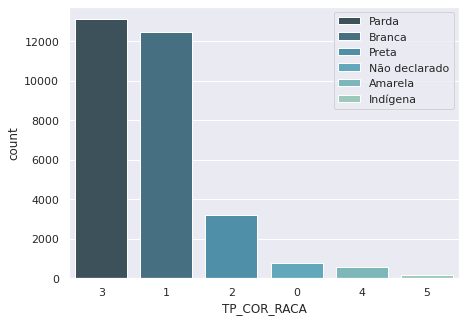

In [11]:
categorias = ["Não declarado",
              "Branca",
              "Preta",
              "Parda",
              "Amarela",
              "Indígena"]

eda_counterplot(microdados, "TP_COR_RACA", categorias, (7,5),
               color_palette=sns.color_palette("GnBu_d", n_colors=6))

# plt.savefig('var_cor_raca.svg', bbox_inches = 'tight')

## Sobre o ensino médio do candidato

* Em sua maioria, os candidatos já concluíram o EM ou são concluintes do EM em 2019.
* Não foram observados casos de candidatos que concluem o EM após 2019.

Concluiu EM : 21320 (70.52%)
Cursando e concluinte em 2019 : 8754 (28.96%)
Não concluiu e não cursa EM : 159 (0.53%)


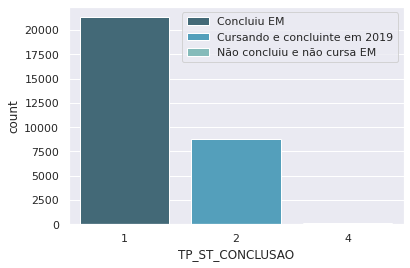

In [12]:
categorias = {1: "Concluiu EM",
              2: "Cursando e concluinte em 2019",
              3: "Cursando e concluinte após 2019",
              4: "Não concluiu e não cursa EM"}
eda_counterplot(microdados, "TP_ST_CONCLUSAO", categorias, (6,4),
               color_palette=sns.color_palette("GnBu_d", n_colors=3))

# plt.savefig('var_tp_st_conclusao.svg', bbox_inches = 'tight')

### Com relação ao ano de conclusão:
* A maioria dos candidatos não comunicou o ano em que seus cursos foram concluídos. 
* A quantidade de candidatos que não responderam ao questionamento é muito grande e precisa de uma averiguação mais apurada.

Não informado : 9911 (32.78%)
Antes de 2007 : 3888 (12.86%)
2018 : 3667 (12.13%)
2017 : 2526 (8.36%)
2016 : 2012 (6.65%)
2015 : 1630 (5.39%)
2014 : 1394 (4.61%)
2013 : 1122 (3.71%)
2012 : 956 (3.16%)
2011 : 755 (2.50%)
2010 : 692 (2.29%)
2009 : 654 (2.16%)
2008 : 531 (1.76%)
2007 : 495 (1.64%)


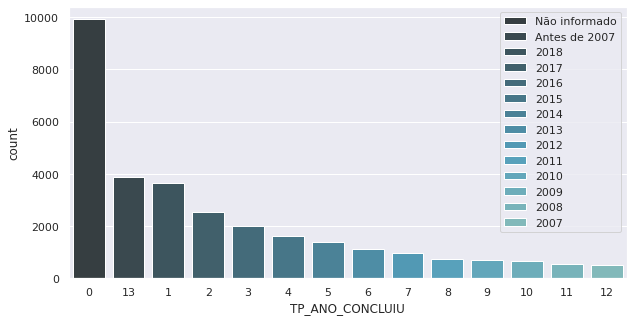

In [13]:
categorias = {0:"Não informado",
            1:"2018",
            2:"2017",
            3:"2016",
            4:"2015",
            5:"2014",
            6:"2013",
            7:"2012",
            8:"2011",
            9:"2010",
            10:"2009",
            11:"2008",
            12:"2007",
            13:"Antes de 2007"}
eda_counterplot(microdados, "TP_ANO_CONCLUIU", categorias, (10,5), 
                color_palette=sns.color_palette("GnBu_d", n_colors=18))

# plt.savefig('var_ano_concluiu.svg', bbox_inches = 'tight')

### Com relação ao tipo de escola em que cursaram o ensino médio:
* A maioria dos candidatos optou por não responder.
* Dentre os que responderam, a maioria é de escola pública e uma parcela menor é de escola privada.

Não Respondeu : 21479 (71.04%)
Pública : 6017 (19.90%)
Privada : 2737 (9.05%)


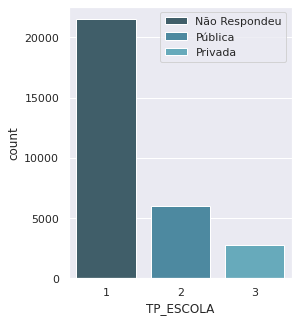

In [14]:
categorias= {1: "Não Respondeu",
             2: "Pública",
             3: "Privada",
             4: "Exterior"}
eda_counterplot(microdados, "TP_ESCOLA", categorias, (4,5), 
                color_palette=sns.color_palette("GnBu_d", n_colors=4))

# plt.savefig('var_tp_escola.svg', bbox_inches = 'tight')

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


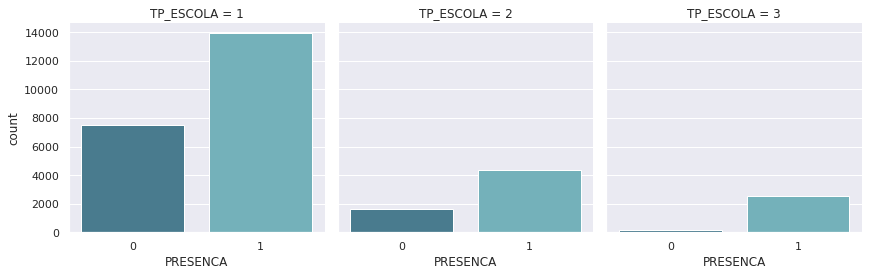

In [15]:
eda_catplot_geral(microdados,"PRESENCA", "TP_ESCOLA", 3)
# plt.savefig('cat_presenca_tp_escola.svg', bbox_inches = 'tight')

### Sobre a localização da escola onde o candidato fez o Ensino Médio:
* Em sua grande maioria, as escolas estão localizadas em zonas urbanas e estão em funcionamento.

Urbana : 6337 (97.90%)
Rural : 136 (2.10%)


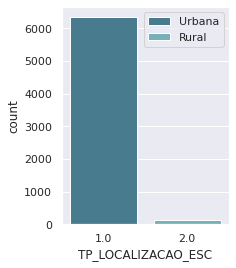

In [16]:
eda_counterplot(microdados, "TP_LOCALIZACAO_ESC", {1: "Urbana", 2: "Rural"}, (3,4),
               color_palette=sns.color_palette("GnBu_d", n_colors=2))

# plt.savefig('var_tp_localizacao_esc.svg', bbox_inches = 'tight')

Ativa : 6455 (99.72%)
Paralisada : 12 (0.19%)
NA : 4 (0.06%)
Extinta : 2 (0.03%)


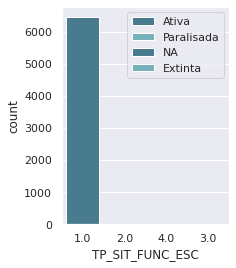

In [17]:
eda_counterplot(microdados, "TP_SIT_FUNC_ESC", 
                {1: "Ativa", 2: "Paralisada", 3:"Extinta", 4:"NA"},(3,4), 
                color_palette=sns.color_palette("GnBu_d", n_colors=2))

# plt.savefig('var_tp_sit_func_esc.svg', bbox_inches = 'tight')

## Sobre a solicitação de atendimento especializado ou específico

Na inscrição, os candidatos podem solicitar um atendimento especializado ou específico. Os casos serão os considerados a seguir.

1) Dados sobre pedidos de atendimento especializado.
* Candidatos com necessidades especiais.
* Precisam de um ambiente específico para realização das provas ou necessitam da presença de profissionais capacitados.

2) Dados sobre pedidos de atendimento específico.
* Exemplos: gestantes, lactantes, idosos ou hospitalizado.
    



Total de candidatos: 39014
IN_DEFICIT_ATENCAO : 7392 (18.9%)
IN_DEFICIENCIA_FISICA : 7077 (18.1%)
IN_SEM_RECURSO : 5673 (14.5%)
IN_LACTANTE : 3559 (9.1%)
IN_OUTRA_DEF : 2709 (6.9%)
IN_DEFICIENCIA_MENTAL : 2112 (5.4%)
IN_DEFICIENCIA_AUDITIVA : 2047 (5.2%)
IN_SURDEZ : 1530 (3.9%)
IN_GESTANTE : 1374 (3.5%)
IN_DISLEXIA : 1324 (3.4%)
IN_VISAO_MONOCULAR : 1054 (2.7%)
IN_AUTISMO : 1023 (2.6%)
IN_BAIXA_VISAO : 870 (2.2%)
IN_CEGUEIRA : 655 (1.7%)
IN_DISCALCULIA : 323 (0.8%)
IN_IDOSO : 229 (0.6%)
IN_SURDO_CEGUEIRA : 42 (0.1%)
IN_ESTUDA_CLASSE_HOSPITALAR : 21 (0.1%)


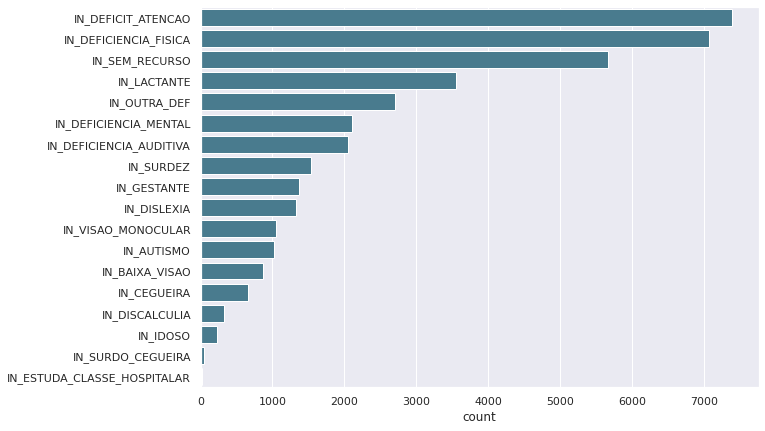

In [18]:
####################################
# Função de plot para antendimento
####################################
def eda_candidatos_nesp(dados, fig_size, debug=False):
    cat_nesp = ["IN_BAIXA_VISAO", "IN_CEGUEIRA", "IN_SURDEZ", "IN_DEFICIENCIA_AUDITIVA",
                "IN_SURDO_CEGUEIRA", "IN_DEFICIENCIA_FISICA", "IN_DEFICIENCIA_MENTAL",
                "IN_DEFICIT_ATENCAO", "IN_DISLEXIA", "IN_DISCALCULIA","IN_AUTISMO",
                "IN_VISAO_MONOCULAR", "IN_OUTRA_DEF", "IN_GESTANTE", "IN_LACTANTE",
                "IN_IDOSO", "IN_ESTUDA_CLASSE_HOSPITALAR", "IN_SEM_RECURSO"]
    
    # organizando o dataframe com os dados dos candidatos
    candidatos = dados[cat_nesp].copy()
    candidatos_count = pd.melt(candidatos)
    
    # contagem de categorias + sort
    cat_count = {k: candidatos[k].value_counts()[1] for k in cat_nesp}
    cat_count_sorted = {k: v for k, v in sorted(cat_count.items(), key=lambda item: item[1], reverse=True)}
    
    if debug:
        print("Original \n", cat_count)
        print("Ordenado \n", cat_count_sorted)    

    
    total = sum(cat_count_sorted.values())
    #for index, value in counter.items():
    #    perc = (value * 100) / total
    #    print(categorias[index],":", value, '({:1.1f}%)'.format(perc))
    print("Total de candidatos:", total)
    for key, value in cat_count_sorted.items():
        perc = (value * 100) / total
        print(key, ":", value, '({:1.1f}%)'.format(perc))
    
    # plot do gráfico
    f, ax = plt.subplots(figsize = fig_size)
    plot = sns.countplot(data = candidatos_count[candidatos_count["value"]==1], 
                  y = 'variable', 
                  hue = 'value',
                  order = list(cat_count_sorted.keys()),
                  dodge=False,
                  palette=sns.color_palette("GnBu_d", n_colors=2))
    plot.set_ylabel("")
    ax.get_legend().remove()
    
eda_candidatos_nesp(microdados, (10,7))

# plt.savefig('var_cat_solicitacao.svg', bbox_inches = 'tight')

## Analisando a relação bivariada com a presença na prova

* Objetiva-se verificar a relação entre as categorias de atendimento solicitados e o comparecimento ou ausência na prova.



Presente : 6223 (84.19%)
Ausente : 1169 (15.81%)


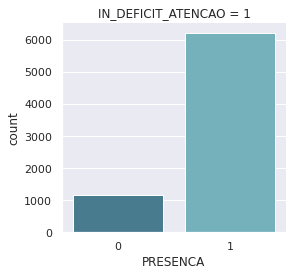

In [19]:
eda_catplot(microdados,"PRESENCA", "IN_DEFICIT_ATENCAO")

# plt.savefig('var_presenca_deficit_atencao.svg', bbox_inches = 'tight')

Presente : 4734 (66.89%)
Ausente : 2343 (33.11%)


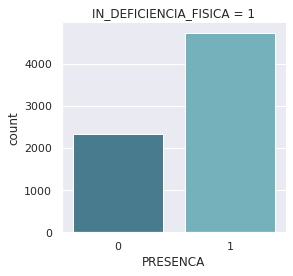

In [20]:
eda_catplot(microdados,"PRESENCA", "IN_DEFICIENCIA_FISICA")

# plt.savefig('var_presenca_deficiencia_fisica.svg', bbox_inches = 'tight')

Presente : 1533 (72.59%)
Ausente : 579 (27.41%)


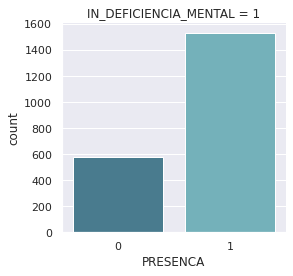

In [21]:
eda_catplot(microdados,"PRESENCA", "IN_DEFICIENCIA_MENTAL")

# plt.savefig('var_presenca_deficiencia_mental.svg', bbox_inches = 'tight')

Presente : 1540 (75.23%)
Ausente : 507 (24.77%)


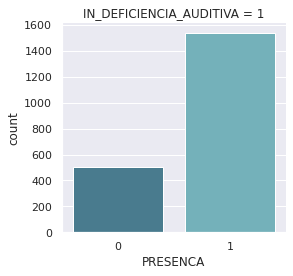

In [22]:
eda_catplot(microdados,"PRESENCA", "IN_DEFICIENCIA_AUDITIVA")

# plt.savefig('var_presenca_in_deficiencia_auditiva.svg', bbox_inches = 'tight')

Presente : 1119 (73.14%)
Ausente : 411 (26.86%)


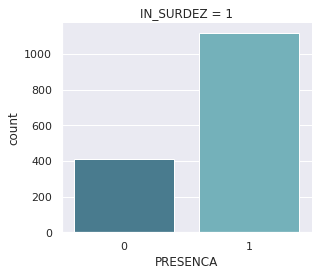

In [23]:
eda_catplot(microdados,"PRESENCA", "IN_SURDEZ", 2)

# plt.savefig('var_presenca_surdez.svg', bbox_inches = 'tight')

Presente : 1122 (84.74%)
Ausente : 202 (15.26%)


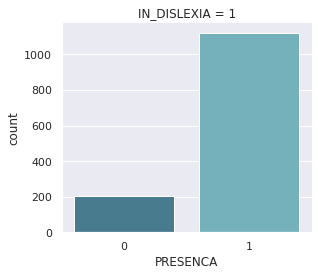

In [24]:
eda_catplot(microdados,"PRESENCA", "IN_DISLEXIA", 2)

# plt.savefig('var_presenca_dislexia.svg', bbox_inches = 'tight')

Presente : 729 (69.17%)
Ausente : 325 (30.83%)


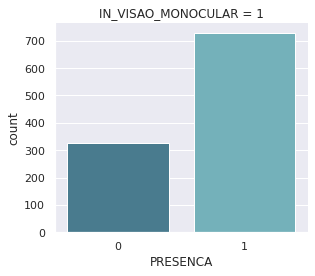

In [25]:
eda_catplot(microdados,"PRESENCA", "IN_VISAO_MONOCULAR", 2)

# plt.savefig('var_presenca_in_visao_monocular.svg', bbox_inches = 'tight')

Presente : 810 (79.18%)
Ausente : 213 (20.82%)


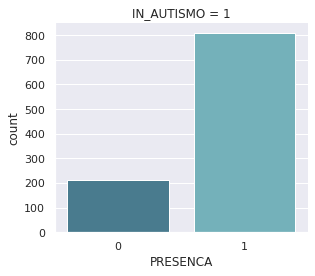

In [26]:
eda_catplot(microdados,"PRESENCA", "IN_AUTISMO", 2)

# plt.savefig('var_presenca_autismo.svg', bbox_inches = 'tight')

Presente : 593 (68.16%)
Ausente : 277 (31.84%)


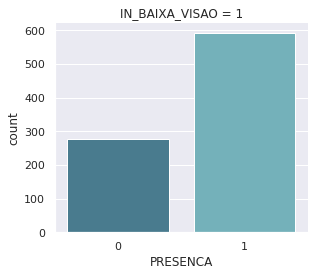

In [27]:
eda_catplot(microdados,"PRESENCA", "IN_BAIXA_VISAO", 2)

# plt.savefig('var_presenca_in_visao_baixa.svg', bbox_inches = 'tight')

Presente : 490 (74.81%)
Ausente : 165 (25.19%)


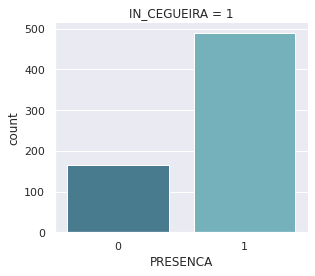

In [28]:
eda_catplot(microdados,"PRESENCA", "IN_CEGUEIRA", 2)

# plt.savefig('var_presenca_in_cegueira.svg', bbox_inches = 'tight')

Presente : 272 (84.21%)
Ausente : 51 (15.79%)


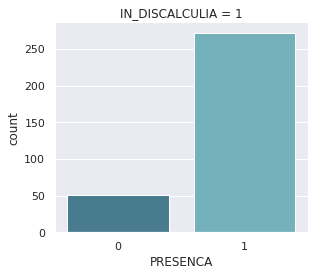

In [29]:
eda_catplot(microdados,"PRESENCA", "IN_DISCALCULIA", 2)

# plt.savefig('var_presenca_in_discalculia.svg', bbox_inches = 'tight')

Presente : 25 (59.52%)
Ausente : 17 (40.48%)


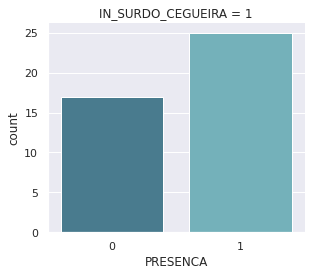

In [30]:
eda_catplot(microdados,"PRESENCA", "IN_SURDO_CEGUEIRA", 2)

# plt.savefig('var_presenca_surdo_cegueira.svg', bbox_inches = 'tight')

Ausente : 2050 (57.60%)
Presente : 1509 (42.40%)


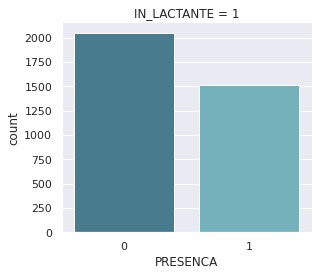

In [31]:
eda_catplot(microdados,"PRESENCA", "IN_LACTANTE", 2)

# plt.savefig('var_presenca_in_lactante.svg', bbox_inches = 'tight')

Ausente : 977 (71.11%)
Presente : 397 (28.89%)


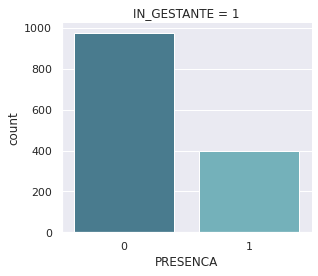

In [32]:
eda_catplot(microdados,"PRESENCA", "IN_GESTANTE", 2)

# plt.savefig('var_presenca_in_gestante.svg', bbox_inches = 'tight')

Presente : 146 (63.76%)
Ausente : 83 (36.24%)


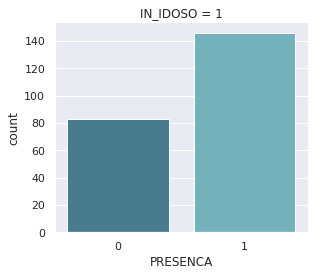

In [33]:
eda_catplot(microdados,"PRESENCA", "IN_IDOSO", 2)

# plt.savefig('var_presenca_in_idoso.svg', bbox_inches = 'tight')

Presente : 11 (52.38%)
Ausente : 10 (47.62%)


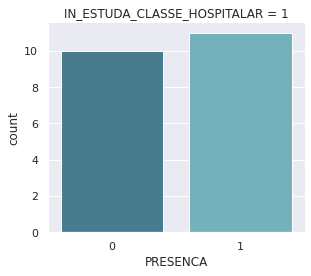

In [34]:
eda_catplot(microdados,"PRESENCA", "IN_ESTUDA_CLASSE_HOSPITALAR", 2)

# plt.savefig('var_presenca_in_estuda_classe_hospitalar.svg', bbox_inches = 'tight')

## Questionário sócio-econômico

### Questão 01: Até que série seu pai, ou o homem responsável por você, estudou?
    1. Nunca estudou.
    2. Não completou a 4ª série/5º ano do Ensino Fundamental.
    3. Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
    4. Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
    5. Completou o Ensino Médio, mas não completou a Faculdade.
    6. Completou a Faculdade, mas não completou a Pós-graduação.
    7. Completou a Pós-graduação.
    8. Não sei.
    
Sobre os níveis de escolaridade do pai, ou o homem responsável pelo candidato:

* **Pós-graduação:** em 7.9% dos casos completou uma Pós-graduação.
* **Graduação:** em 10.7% dos casos possui Ensino Superior.
* **Ensino médio:** em 23.5% dos casos possui Ensino Médio e em 9.3% dos casos, ainda completou não completou o Ensino Médio.
* **Ensino fundamental II:** em 11.8% dos casos, ainda está no Ensino Fundamental (até a 8a série).
* **Ensino fundamental I:** 20.6% dos casos, ainda não completou o Ensino Primário (até a 4a série).
* Em 6.4% dos casos, nunca estudou.  

Completou o Ensino Médio, mas não completou a Faculdade. : 7091 (23.45%)
Não completou a 4ª série/5º ano do Ensino Fundamental : 6218 (20.57%)
Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental. : 3564 (11.79%)
Completou a Faculdade, mas não completou a Pós-graduação. : 3224 (10.66%)
Não sei. : 3001 (9.93%)
Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio. : 2820 (9.33%)
Completou a Pós-graduação. : 2377 (7.86%)
Nunca estudou : 1938 (6.41%)


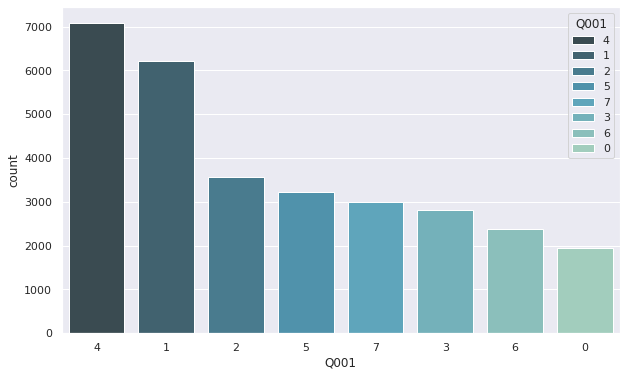

In [35]:
categorias = {0: "Nunca estudou",
    1: "Não completou a 4ª série/5º ano do Ensino Fundamental",
    2: "Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.",
    3: "Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.",
    4: "Completou o Ensino Médio, mas não completou a Faculdade.",
    5: "Completou a Faculdade, mas não completou a Pós-graduação.",
    6: "Completou a Pós-graduação.",
    7: "Não sei."}

eda_counterplot(microdados, "Q001", categorias, (10,6), exibe_cat=False, 
                color_palette=sns.color_palette("GnBu_d", n_colors=8))

# plt.savefig('var_q001.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q001** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


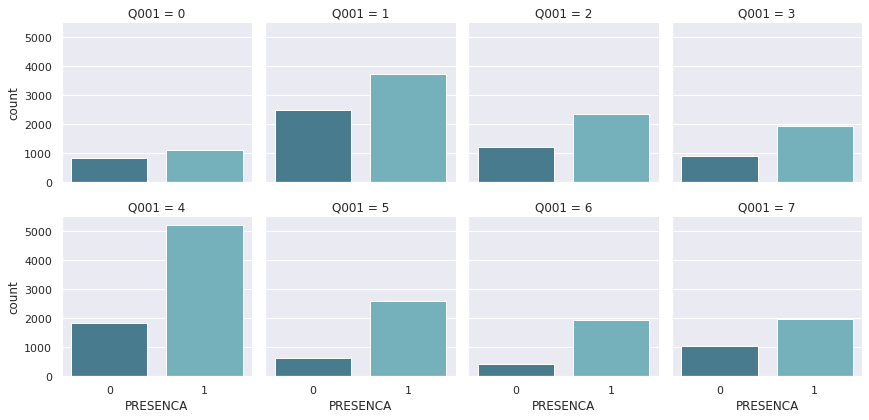

In [36]:
eda_catplot_geral(microdados,"PRESENCA", "Q001", num_col=4, plot_height=3)

# plt.savefig('var_presenca_q001.svg', bbox_inches = 'tight')

### Questão 02: Até que série sua mãe, ou a mulher responsável por você, estudou?
    1. Nunca estudou.
    2. Não completou a 4ª série/5º ano do Ensino Fundamental.
    3. Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
    4. Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
    5. Completou o Ensino Médio, mas não completou a Faculdade.
    6. Completou a Faculdade, mas não completou a Pós-graduação.
    7. Completou a Pós-graduação.
    8. Não sei.
    
Sobre os níveis de escolaridade da mãe ou mulher responsável pelo candidato:

* **Pós-graduação:** em 13.2% dos casos, completou uma Pós-graduação.
* **Graduação:** em 13.1% dos casos, possui Ensino Superior.
* **Ensino médio:** em 28.1% dos casos possui Ensino Médio e em 10.5% dos casos, ainda completou não completou o Ensino Médio.
* **Ensino fundamental II:** em 11.2% dos casos, o pai do candidato ainda está no Ensino Fundamental (até a 8a série).
* **Ensino fundamental I:** 15.5% dos casos, o pai do candidato ainda não completou o Ensino Fundamental (até a 4a série).
* Em 4.7% dos casos, nunca estudou.  

Completou o Ensino Médio, mas não completou a Faculdade. : 8500 (28.11%)
Não completou a 4ª série/5º ano do Ensino Fundamental : 4675 (15.46%)
Completou a Pós-graduação. : 3985 (13.18%)
Completou a Faculdade, mas não completou a Pós-graduação. : 3957 (13.09%)
Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental. : 3400 (11.25%)
Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio. : 3163 (10.46%)
Nunca estudou : 1425 (4.71%)
Não sei. : 1128 (3.73%)


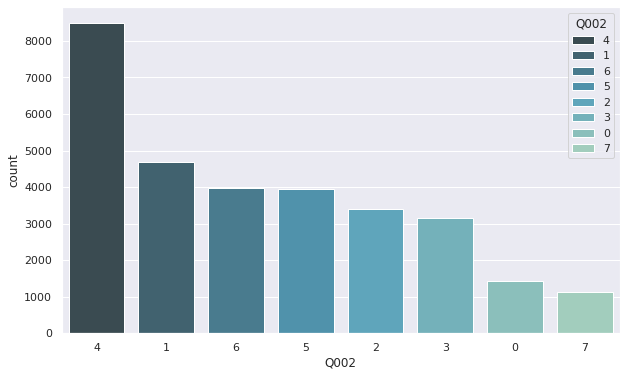

In [37]:
categorias = {0: "Nunca estudou",
    1: "Não completou a 4ª série/5º ano do Ensino Fundamental",
    2: "Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.",
    3: "Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.",
    4: "Completou o Ensino Médio, mas não completou a Faculdade.",
    5: "Completou a Faculdade, mas não completou a Pós-graduação.",
    6: "Completou a Pós-graduação.",
    7: "Não sei."}

eda_counterplot(microdados, "Q002", categorias, (10,6), exibe_cat=False, 
                color_palette=sns.color_palette("GnBu_d", n_colors=8))

# plt.savefig('var_q002.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q002** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


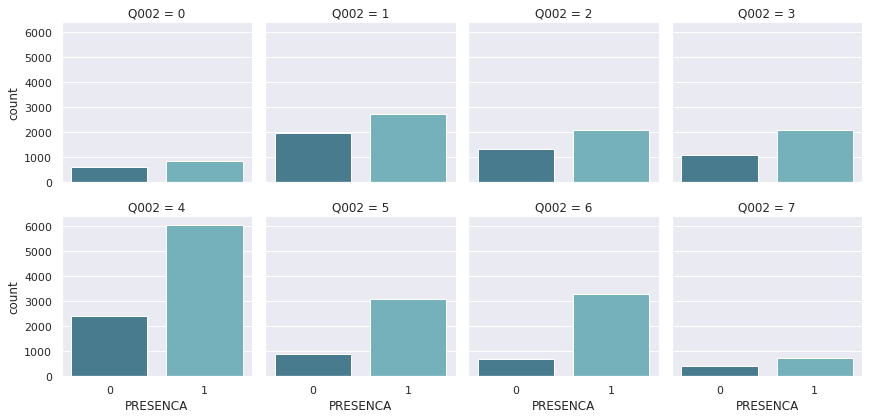

In [38]:
eda_catplot_geral(microdados,"PRESENCA", "Q002", num_col=4, plot_height=3)

# plt.savefig('var_presenca_q002.svg', bbox_inches = 'tight')

### Q003 - Grupo que contempla a ocupação mais próxima da ocupação do seu pai ou do homem responsável.

* Grupo 1: Lavrador, agricultor sem empregados, bóia fria, criador de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultor, pescador, lenhador, seringueiro, extrativista.
* Grupo 2: Diarista, empregado doméstico, cuidador de idosos, babá, cozinheiro (em casas particulares), motorista particular, jardineiro, faxineiro de empresas e prédios, vigilante, porteiro, carteiro, office-boy, vendedor, caixa, atendente de loja, auxiliar administrativo, recepcionista, servente de pedreiro, repositor de mercadoria.
* **Grupo 3:** Padeiro, cozinheiro industrial ou em restaurantes, sapateiro, costureiro, joalheiro, torneiro mecânico, operador de máquinas, soldador, operário de fábrica, trabalhador da mineração, pedreiro, pintor, eletricista, encanador, motorista, caminhoneiro, taxista.
* **Grupo 4:** Professor (de ensino fundamental ou médio, idioma, música, artes etc.), técnico (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretor de imóveis, supervisor, gerente, mestre de obras, pastor, microempresário (proprietário de empresa com menos de 10 empregados), pequeno comerciante, pequeno proprietário de terras, trabalhador autônomo ou por conta própria.
* Grupo 5: Médico, engenheiro, dentista, psicólogo, economista, advogado, juiz, promotor, defensor, delegado, tenente, capitão, coronel, professor universitário, diretor em empresas públicas ou privadas, político, proprietário de empresas com mais de 10 empregados.


Grupo 4 : 5961 (19.72%)
Grupo 3 : 5800 (19.18%)
Grupo 2 : 5676 (18.77%)
Grupo 1 : 5589 (18.49%)
Não sei : 4132 (13.67%)
Grupo 5 : 3075 (10.17%)


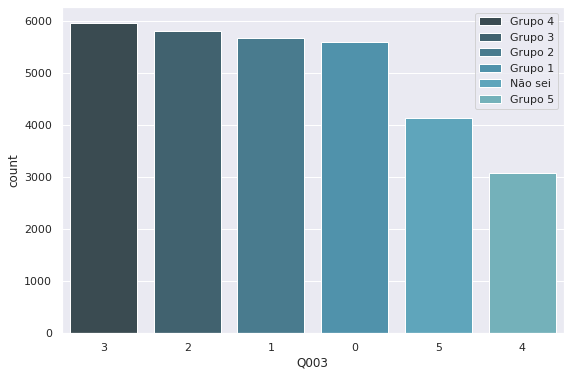

In [39]:
categorias = {0: "Grupo 1",
    1: "Grupo 2",
    2: "Grupo 3",
    3: "Grupo 4",
    4: "Grupo 5",
    5: "Não sei"}

eda_counterplot(microdados, "Q003", categorias, (9,6), 
                color_palette=sns.color_palette("GnBu_d", n_colors=8))

# plt.savefig('var_q003.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q003** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


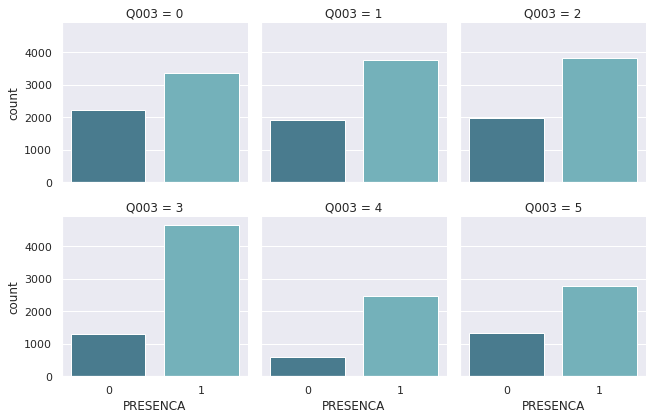

In [40]:
eda_catplot_geral(microdados,"PRESENCA", "Q003", num_col=3, plot_height=3)

# plt.savefig('var_presenca_q003.svg', bbox_inches = 'tight')

### Q004 - Grupo que contempla a ocupação mais próxima da ocupação da sua mãe ou da mulher responsável.


* Grupo 1: Lavradora, agricultora sem empregados, bóia fria, criadora de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultora, pescadora, lenhadora, seringueira, extrativista.
* **Grupo 2:** Diarista, empregada doméstica, cuidadora de idosos, babá, cozinheira (em casas particulares), motorista particular, jardineira, faxineira de empresas e prédios, vigilante, porteira, carteira, office-boy, vendedora, caixa, atendente de loja, auxiliar administrativa, recepcionista, servente de pedreiro, repositora de mercadoria.
* Grupo 3: Padeira, cozinheira industrial ou em restaurantes, sapateira, costureira, joalheira, torneira mecânica, operadora de máquinas, soldadora, operária de fábrica, trabalhadora da mineração, pedreira, pintora, eletricista, encanadora, motorista, caminhoneira, taxista.
* **Grupo 4:** Professora (de ensino fundamental ou médio, idioma, música, artes etc.), técnica (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretora de imóveis, supervisora, gerente, mestre de obras, pastora, microempresária (proprietária de empresa com menos de 10 empregados), pequena comerciante, pequena proprietária de terras, trabalhadora autônoma ou por conta própria.
* Grupo 5: Médica, engenheira, dentista, psicóloga, economista, advogada, juíza, promotora, defensora, delegada, tenente, capitã, coronel, professora universitária, diretora em empresas públicas ou privadas, política, proprietária de empresas com mais de 10 empregados.

Grupo 2 : 10958 (36.25%)
Grupo 4 : 7362 (24.35%)
Grupo 1 : 4567 (15.11%)
Não sei : 3286 (10.87%)
Grupo 5 : 2382 (7.88%)
Grupo 3 : 1678 (5.55%)


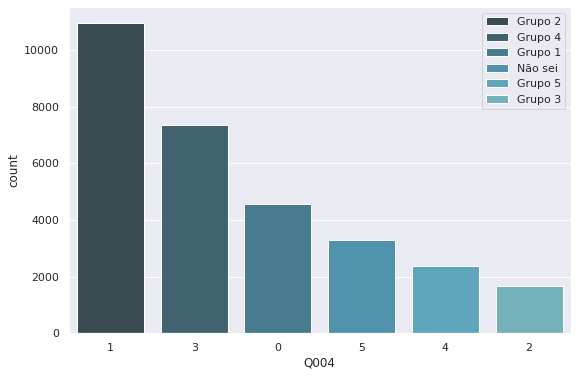

In [41]:
categorias = {0: "Grupo 1",
    1: "Grupo 2",
    2: "Grupo 3",
    3: "Grupo 4",
    4: "Grupo 5",
    5: "Não sei"}

eda_counterplot(microdados, "Q004", categorias, (9,6), 
                color_palette=sns.color_palette("GnBu_d", n_colors=8))

# plt.savefig('var_q004.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q004** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


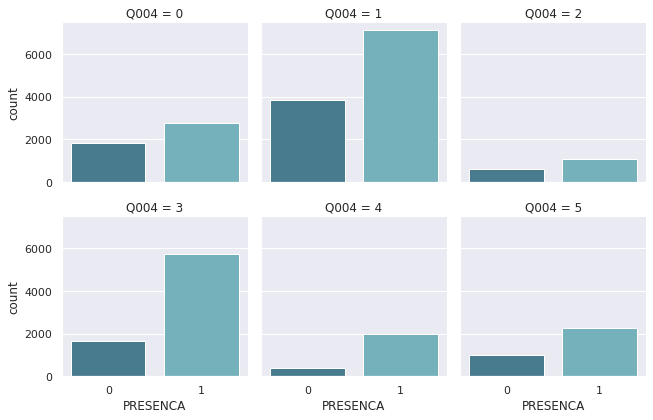

In [42]:
eda_catplot_geral(microdados,"PRESENCA", "Q004", num_col=3, plot_height=3)

# plt.savefig('var_presenca_q004.svg', bbox_inches = 'tight')

### Q005 - Incluindo você, quantas pessoas moram atualmente em sua residência?

* A maior parcela dos candidatos mora com até 5 pessoas na residência.

4 : 8822 (29.18%)
3 : 8152 (26.96%)
2 : 4813 (15.92%)
5 : 4220 (13.96%)
6 : 1553 (5.14%)
Moro sozinho(a) : 1458 (4.82%)
7 : 672 (2.22%)
8 : 260 (0.86%)
9 : 109 (0.36%)
10 : 92 (0.30%)
11 : 28 (0.09%)
12 : 20 (0.07%)
19 : 12 (0.04%)
14 : 6 (0.02%)
13 : 5 (0.02%)
15 : 4 (0.01%)
16 : 4 (0.01%)
18 : 2 (0.01%)
17 : 1 (0.00%)


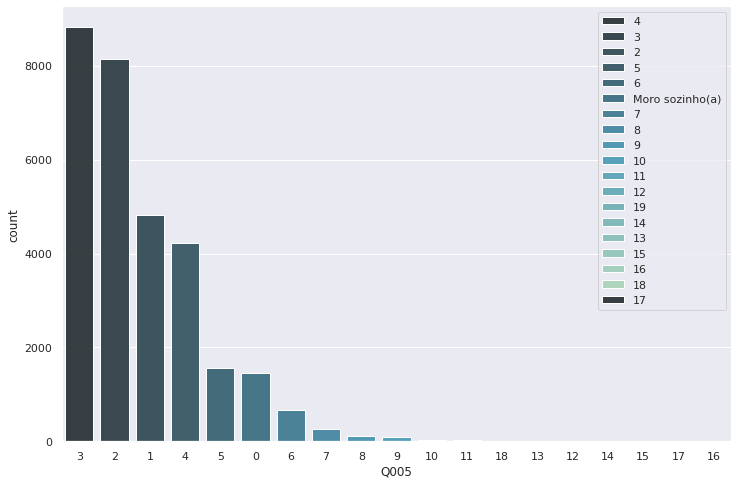

In [43]:
categorias ={0:"Moro sozinho(a)", 1:"2", 2:"3", 3:"4", 4:"5", 
    5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11", 
    11:"12", 12:"13", 13:"14", 14:"15", 
    15:"16", 16:"17", 17:"18", 18:"19", 19:"20"}

eda_counterplot(microdados, "Q005", categorias, (12,8), 
                color_palette=sns.color_palette("GnBu_d", n_colors=18))

# plt.savefig('var_q005.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q005** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


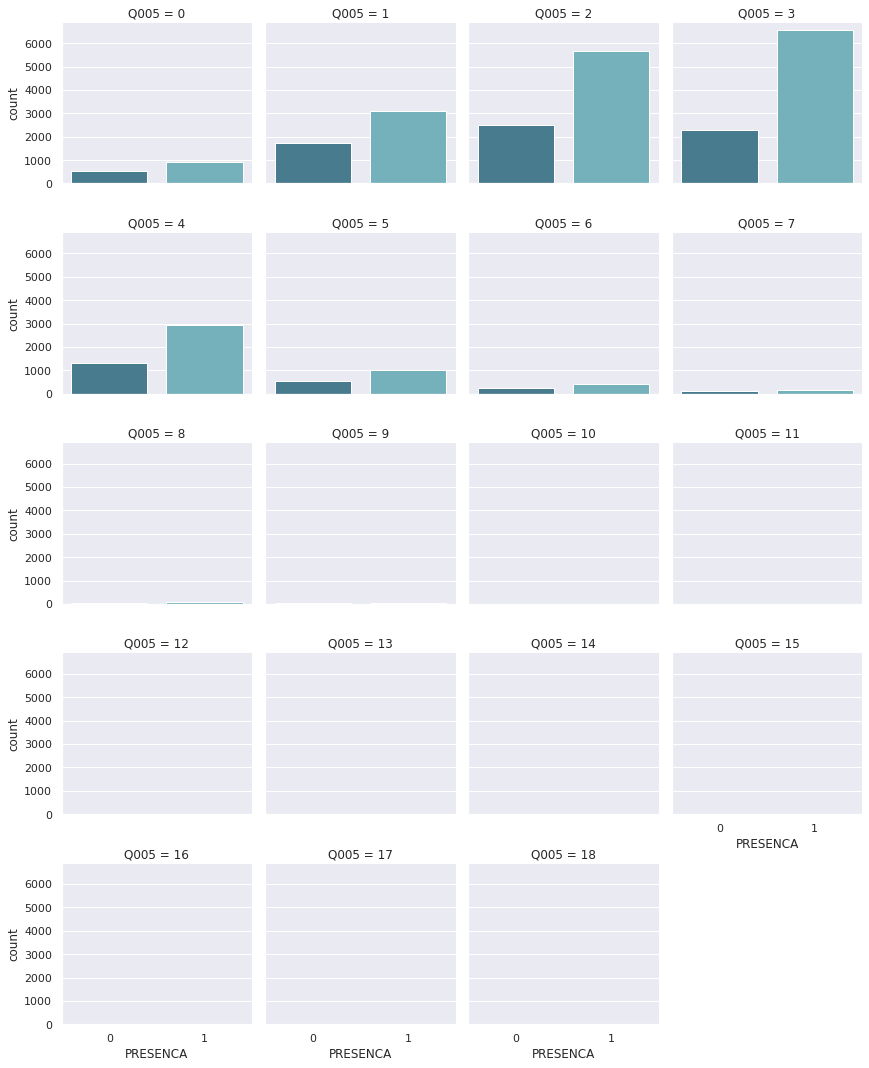

In [48]:
eda_catplot_geral(microdados,"PRESENCA", "Q005", num_col=4, plot_height=3)

plt.savefig('var_presenca_q005.svg', bbox_inches = 'tight')

### Q006 - Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)

* A maior parte dos candidatos declarou renda mensal familiar de até R$ 1.497,00.
* 4.3% dos candidatos declararam não ter renda familiar.

998,01 - R$ 1.497,00 : 7066 (23.37%)
Até 998,00 : 7064 (23.37%)
1.497,01 - 1.996,00 : 2638 (8.73%)
1.996,01 - 2.495,00 : 2497 (8.26%)
2.994,01 - 3.992,00 : 1681 (5.56%)
3.992,01 - 4.990,00 : 1311 (4.34%)
2.495,01 - 2.994,00 : 1246 (4.12%)
Nenhuma renda : 1213 (4.01%)
4.990,01 - 5.988,00 : 1056 (3.49%)
Mais de R$ 19.960,00 : 814 (2.69%)
9.980,01 - 11.976,00 : 636 (2.10%)
5.988,01 - 6.986,00 : 622 (2.06%)
14.970,01 - 19.960,00 : 560 (1.85%)
11.976,01 - 14.970,00 : 535 (1.77%)
6.986,01 - 7.984,00 : 445 (1.47%)
8.982,01 - 9.980,00 : 428 (1.42%)
7.984,01 - 8.982,00 : 421 (1.39%)


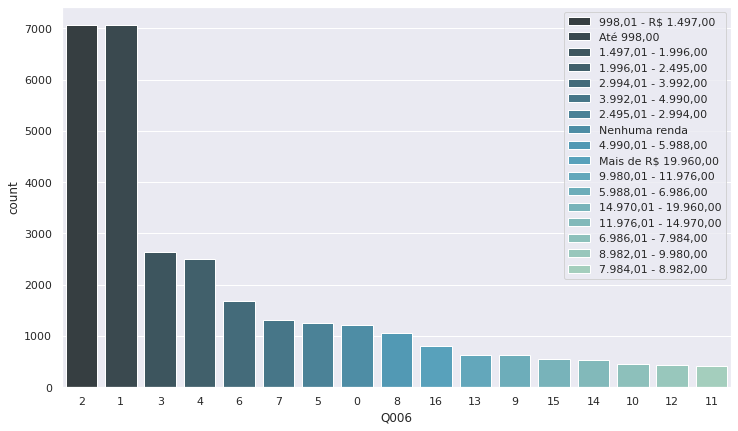

In [44]:
categorias ={0:"Nenhuma renda",
    1:"Até 998,00",
    2:"998,01 - R$ 1.497,00",
    3:"1.497,01 - 1.996,00",
    4:"1.996,01 - 2.495,00",
    5:"2.495,01 - 2.994,00",
    6:"2.994,01 - 3.992,00",
    7:"3.992,01 - 4.990,00",
    8:"4.990,01 - 5.988,00",
    9:"5.988,01 - 6.986,00",
    10:"6.986,01 - 7.984,00",
    11:"7.984,01 - 8.982,00",
    12:"8.982,01 - 9.980,00",
    13:"9.980,01 - 11.976,00",
    14:"11.976,01 - 14.970,00",
    15:"14.970,01 - 19.960,00",
    16:"Mais de R$ 19.960,00"}

eda_counterplot(microdados, "Q006", categorias, (12,7), 
                color_palette=sns.color_palette("GnBu_d", n_colors=18))

# plt.savefig('var_q006.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q006** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


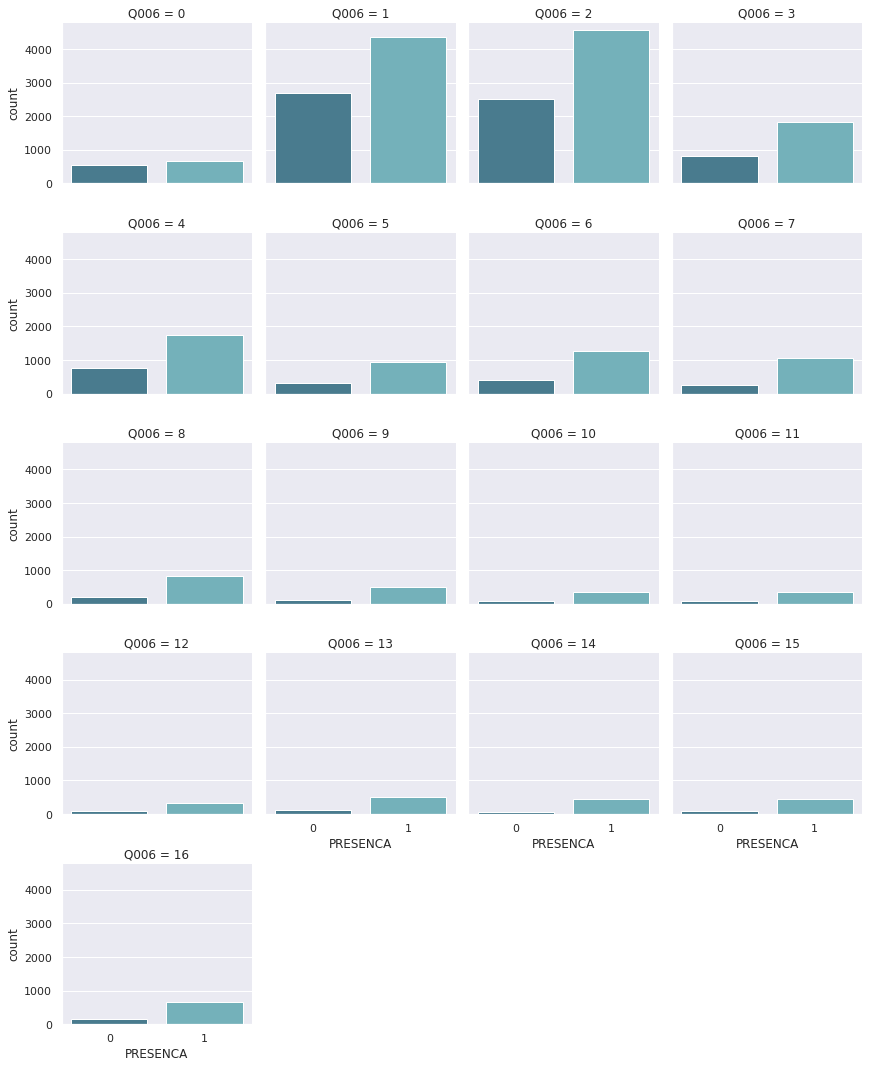

In [45]:
eda_catplot_geral(microdados,"PRESENCA", "Q006", num_col=4, plot_height=3)

# plt.savefig('var_presenca_q006.svg', bbox_inches = 'tight')

### Q010 - Na sua residência tem carro?

Não : 16051 (53.09%)
Sim, um : 10487 (34.69%)
Sim, dois : 3003 (9.93%)
Sim, três : 541 (1.79%)
Sim, quatro ou mais : 151 (0.50%)


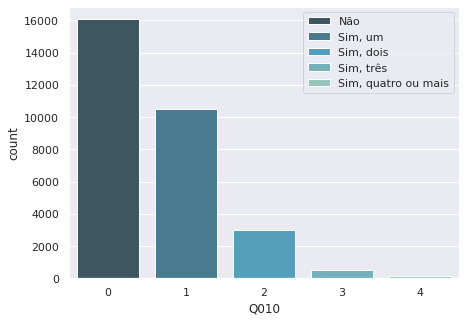

In [46]:
categorias ={0:"Não", 1:"Sim, um",
        2:"Sim, dois", 3:"Sim, três", 4:"Sim, quatro ou mais"}

eda_counterplot(microdados, "Q010", categorias, (7,5),
               color_palette=sns.color_palette("GnBu_d", n_colors=5))

# plt.savefig('var_q010.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q010** e a variável alvo **PRESENÇA**.

* Dos candidatos que declararam não possuir carro (Q010=0), aproximadamente 6 mil candidatos faltaram aos dias de prova e 10 mil compareceram. 

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


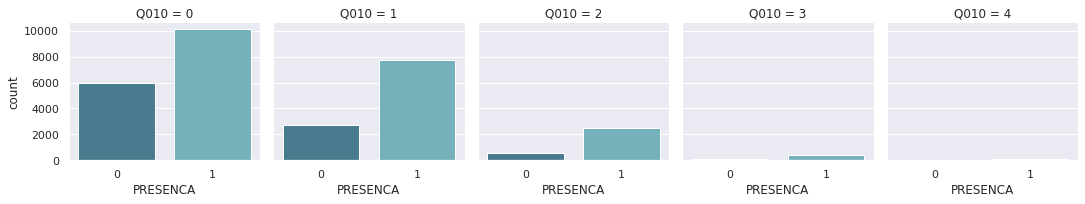

In [47]:
eda_catplot_geral(microdados,"PRESENCA", "Q010", num_col= 5, plot_height=3)

# plt.savefig('var_presenca_q010.svg', bbox_inches = 'tight')

### Q011 - Na sua residência tem motocicleta?

Não : 25104 (83.04%)
Sim, uma : 4702 (15.55%)
Sim, duas : 370 (1.22%)
Sim, três : 51 (0.17%)
Sim, quatro ou mais : 6 (0.02%)


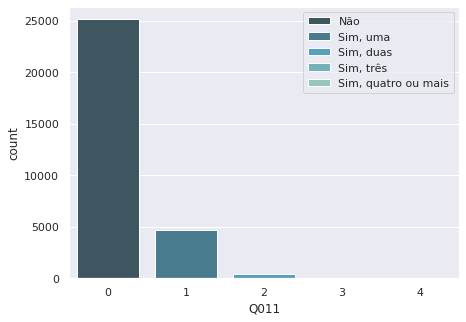

In [48]:
categorias ={0:"Não", 1:"Sim, uma",
        2:"Sim, duas", 3:"Sim, três", 4:"Sim, quatro ou mais"}

eda_counterplot(microdados, "Q011", categorias, (7,5),
               color_palette=sns.color_palette("GnBu_d", n_colors=5))

# plt.savefig('var_q011.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q011** e a variável alvo **PRESENÇA**.

* Dos candidatos que declararam não possuir motocicleta (Q011=0), aproximadamente 8 mil candidatos faltaram aos dias de prova e 18 mil compareceram. 

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


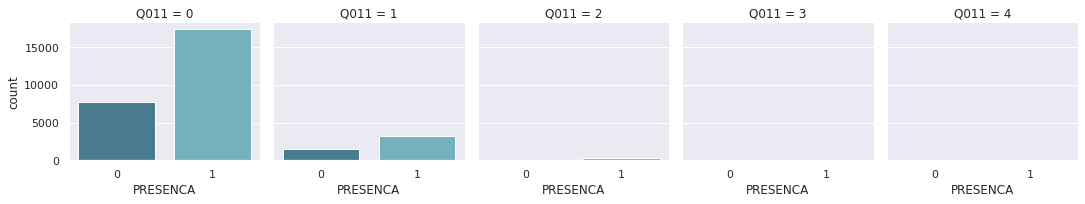

In [49]:
eda_catplot_geral(microdados,"PRESENCA", "Q011", num_col=5, plot_height=3)

# plt.savefig('var_presenca_q011.svg', bbox_inches = 'tight')

### Q022 - Na sua residência tem telefone celular?

* Apenas uma pequena parcela dos candidatos (2.2%) não possui telefone celular na residência.

Sim, dois : 9517 (31.48%)
Sim, três : 7363 (24.35%)
Sim, um : 7315 (24.20%)
Sim, quatro ou mais : 5368 (17.76%)
Não : 670 (2.22%)


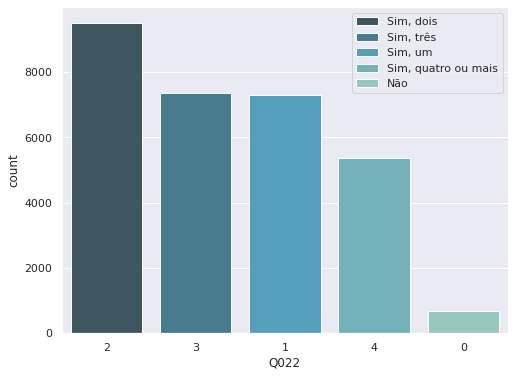

In [50]:
categorias ={0:"Não", 1:"Sim, um",
        2:"Sim, dois", 3:"Sim, três", 4:"Sim, quatro ou mais"}

eda_counterplot(microdados, "Q022", categorias, (8,6),
               color_palette=sns.color_palette("GnBu_d", n_colors=5))

# plt.savefig('var_q022.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q022** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


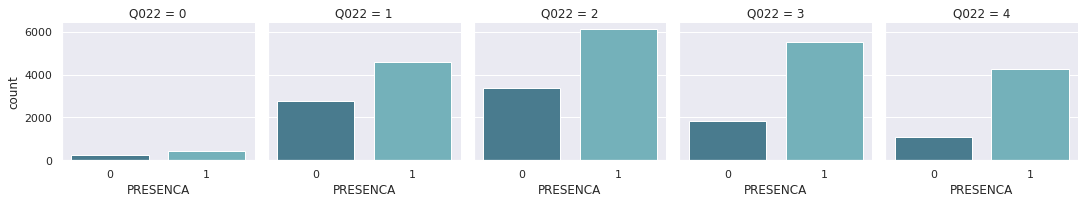

In [51]:
eda_catplot_geral(microdados,"PRESENCA", "Q022", num_col=5, plot_height=3)

# plt.savefig('var_presenca_q022.svg', bbox_inches = 'tight')

### Q024 - Na sua residência tem computador?

* Em uma parcela considerável (38%), os candidatos não possuem computador em sua residência.
* Em 46.2% dos casos, o candidato possui um computador na residência. 

Sim, um : 13967 (46.20%)
Não : 11498 (38.03%)
Sim, dois : 3054 (10.10%)
Sim, três : 1160 (3.84%)
Sim, quatro ou mais : 554 (1.83%)


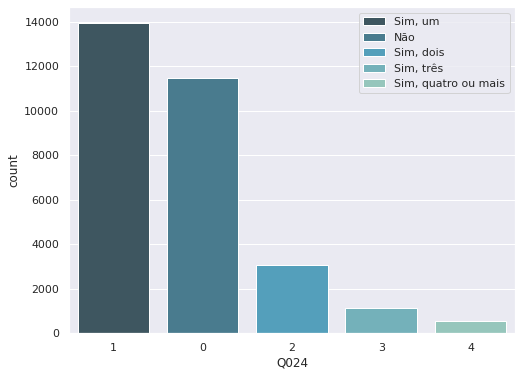

In [52]:
categorias ={0:"Não", 1:"Sim, um",
        2:"Sim, dois", 3:"Sim, três", 4:"Sim, quatro ou mais"}

eda_counterplot(microdados, "Q024", categorias, (8,6),
               color_palette=sns.color_palette("GnBu_d", n_colors=5))

# plt.savefig('var_q024.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q024** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


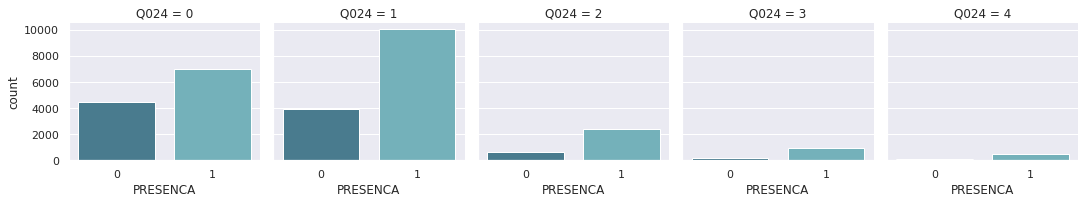

In [53]:
eda_catplot_geral(microdados,"PRESENCA", "Q024", num_col=5, plot_height=3)

# plt.savefig('var_presenca_q024.svg', bbox_inches = 'tight')

### Q025 - Na sua residência tem acesso à Internet?

* Em grande parte, 79.6% dos casos, os candidatos possuem acesso à internet na residência.

Sim : 24070 (79.61%)
Não : 6163 (20.39%)


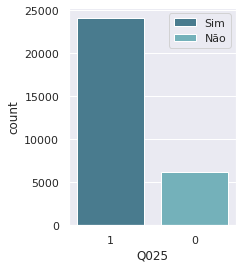

In [54]:
categorias ={0:"Não", 1:"Sim"}
eda_counterplot(microdados, "Q025", categorias, (3,4),
               color_palette=sns.color_palette("GnBu_d", n_colors=2))

# plt.savefig('var_q025.svg', bbox_inches = 'tight')

A seguir, uma análise bivariada entre a coluna **Q025** e a variável alvo **PRESENÇA**.

Presente : 20904 (69.14%)
Ausente : 9329 (30.86%)


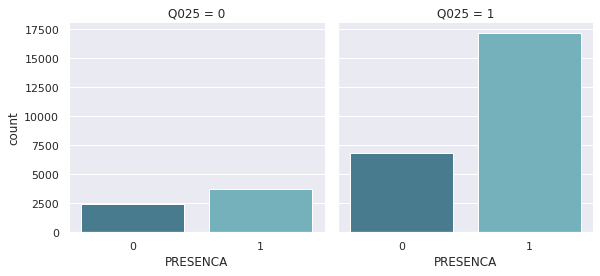

In [55]:
eda_catplot_geral(microdados,"PRESENCA", "Q025", num_col=3, plot_height=4)

# plt.savefig('var_presenca_q025.svg', bbox_inches = 'tight')

## Matriz de correlação

### Correlação entre todas as variáveis

In [56]:
# obs: essa matriz de correlação precisa ser refeita para considerar melhor as
# variáveis categórias.

# colunas que devem ser incluidas na matriz de correlação
corr_incluir = ['NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
       'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
       'Q001', 'Q002', 'Q003', 'Q004',
       'Q005', 'Q006', 'Q010', 'Q011', 'Q022', 'Q024', 'Q025',
       'PRESENCA', 'REGIAO_RESIDENCIA', 'UF_RESIDENCIA',
       'MUNICIPIO_RESIDENCIA', 'REGIAO_PROVA', 'UF_PROVA', 'MUNICIPIO_PROVA'] 

In [57]:
microdados_corr = microdados.copy()
microdados_corr = microdados_corr[corr_incluir]

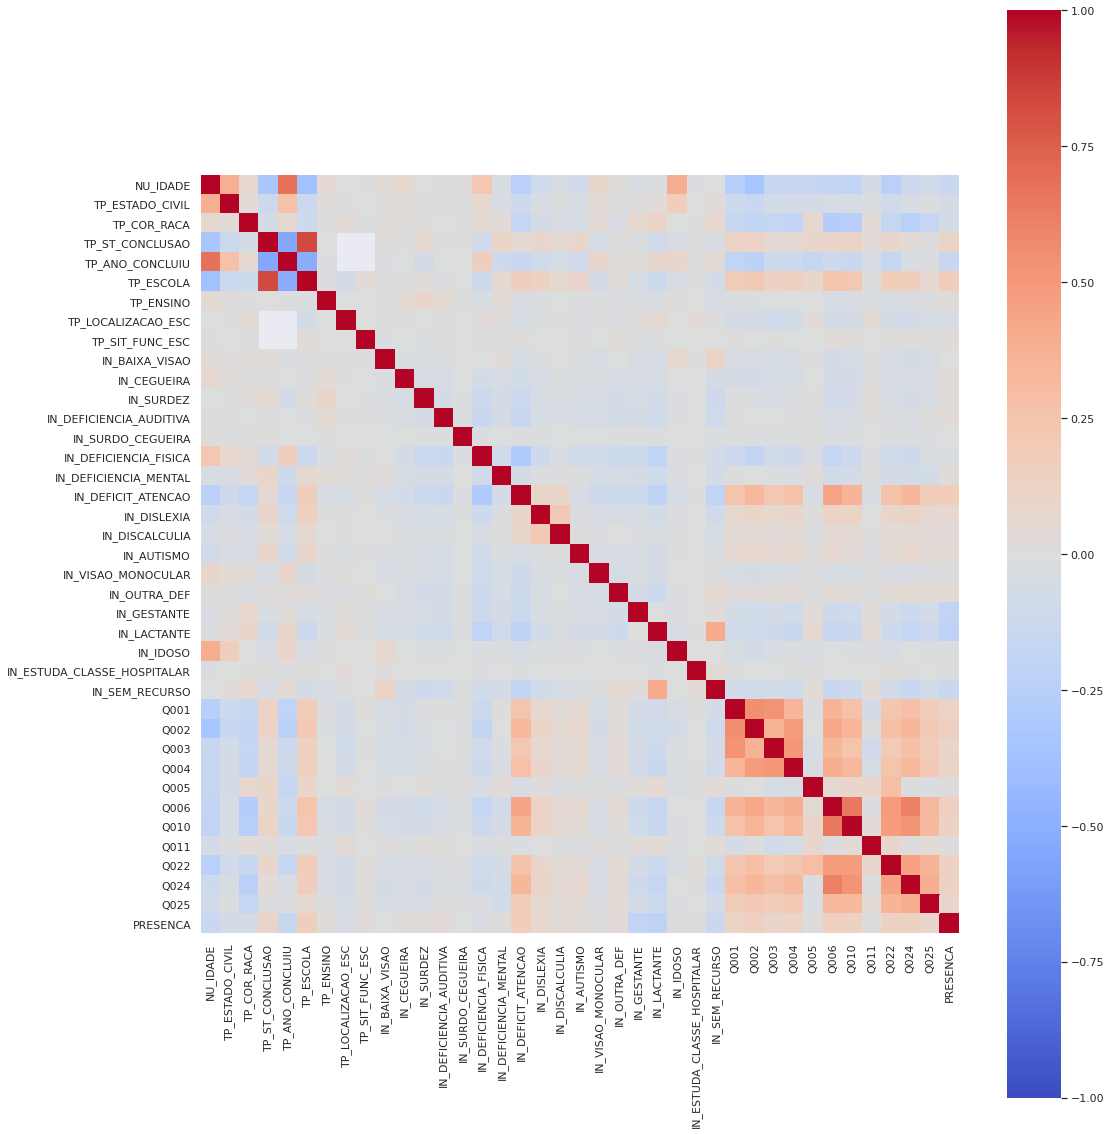

In [58]:
corr = microdados_corr.corr()
f, ax = plt.subplots(figsize = (17,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap= 'coolwarm',
    square=True
)

# plt.savefig('matriz_correlacao.svg', bbox_inches = 'tight')

## Árvore de decisão

In [48]:
microdados_tree = microdados_corr.copy() 
target = microdados_tree["PRESENCA"]

# removendo algumas colunas com valores NaN
# necessita análise posterior
microdados_tree.drop(["TP_ENSINO", "TP_LOCALIZACAO_ESC", "TP_SIT_FUNC_ESC", "PRESENCA"], axis=1, inplace=True)

In [49]:
# checando por NaN
#msno.bar(microdados_tree,figsize=(20, 5),fontsize=10)

In [50]:
# selecionando algumas colunas para a árvore de decisão
colunas_grupo1 = ['IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

colunas_grupo2 = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO']

colunas_quest = ["Q001","Q002","Q003","Q004","Q005","Q006","Q010","Q011","Q022","Q024","Q025"]

In [51]:
microdados_tree = microdados_tree[colunas_quest]

In [52]:
microdados_tree

,Q001,Q002,Q003,Q004,Q005,Q006,Q010,Q011,Q022,Q024,Q025
57,7,7,5,5,2,0,0,0,3,0,1
185,4,3,3,1,1,6,0,0,2,1,1
232,1,3,2,1,1,1,0,0,2,0,0
434,2,1,1,1,1,0,0,0,1,0,0
755,0,0,1,1,2,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5095262,4,2,2,0,6,2,0,0,4,1,1
5095263,1,0,1,0,1,2,0,1,2,1,1
5095264,1,3,0,0,2,1,1,0,2,0,1
5095265,7,5,5,3,0,2,0,0,1,0,1


In [53]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(microdados_tree, target)

DecisionTreeClassifier()

In [44]:
import pydotplus

In [55]:
columns=list(microdados_tree.columns)

dot_data = export_graphviz(decision_tree, out_file=None, feature_names=columns, class_names=True)

#pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.set_size('"20,20!"')

#gvz_graph = graphviz.Source(pydot_graph.to_string())

#graph = graphviz.Source(dot_data)
#graph.render("arvore_decisao_socio_econ",view=True)#, format="svg")

'arvore_decisao_socio_econ.pdf'

In [60]:
microdados.to_csv("/home/ryganon/Downloads/dados enem 2019/microdados_arvore_decisao.csv")